# 时序差分(Temporal Difference)之SARSA

## 载入相关套件

In [1]:
import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
from collections import defaultdict
from lib.envs.windy_gridworld import WindyGridworldEnv
from lib import plotting

matplotlib.style.use('ggplot') # 设定绘图的风格

## 建立环境

In [2]:
env = WindyGridworldEnv()

## 试玩

In [4]:
print(env.reset()) # 重置
env.render()       # 更新画面

print(env.step(1)) # 走下一步
env.render()       # 更新画面

print(env.step(1)) # 走下一步
env.render()       # 更新画面

print(env.step(1)) # 走下一步
env.render()       # 更新画面

print(env.step(1)) # 走下一步
env.render()       # 更新画面

print(env.step(1)) # 走下一步
env.render()       # 更新画面

print(env.step(1)) # 走下一步
env.render()       # 更新画面

30
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

(31, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

(32, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

(33, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

(24, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o 

## 定义 ε-greedy策略

In [5]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    def policy_fn(observation):
        # 每个行动的机率初始化，均为 ε / n
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        # 最佳行动的机率再加 1 - ε 
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

## 定义 SARSA 策略

In [15]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    # 行动值函数初始化
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # 记录 所有回合的长度及奖励
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # 使用 ε-greedy策略
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # 实验 N 回合
    for i_episode in range(num_episodes):
        # 每 100 回合显示除错讯息
        if (i_episode + 1) % 100 == 0:
            print(f"\r {(i_episode + 1)}/{num_episodes}回合.", end="")
            sys.stdout.flush() # 清除画面
        
        # 开始依策略实验
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        # 每次走一步就更新状态值
        for t in itertools.count():
            # 走一步
            next_state, reward, done, _ = env.step(action)
            
            # 选择下一步行动
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs))
                                           , p=next_action_probs)
            
            # 更新长度及奖励
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # 更新状态值
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
    
            if done:
                break
                
            action = next_action
            state = next_state        
    
    return Q, stats

## 执行 SARSA 策略

In [16]:
Q, stats = sarsa(env, 200)

 200/200回合.

## 显示结果

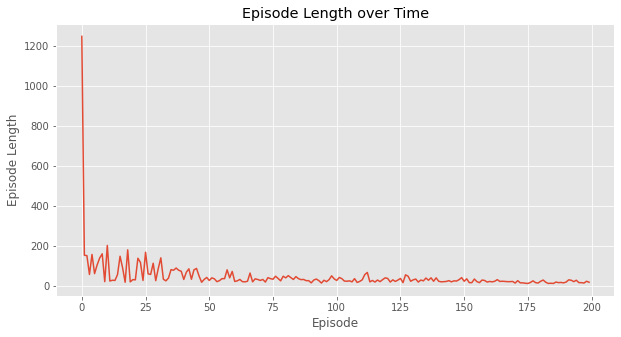

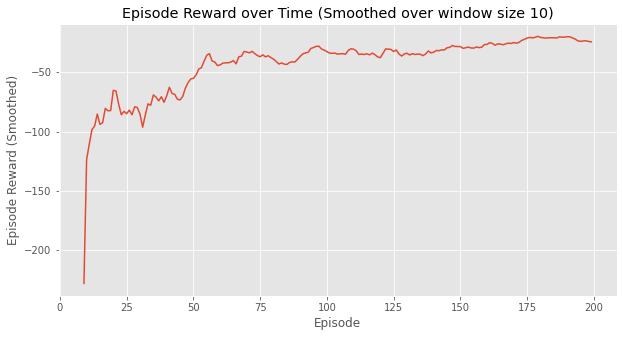

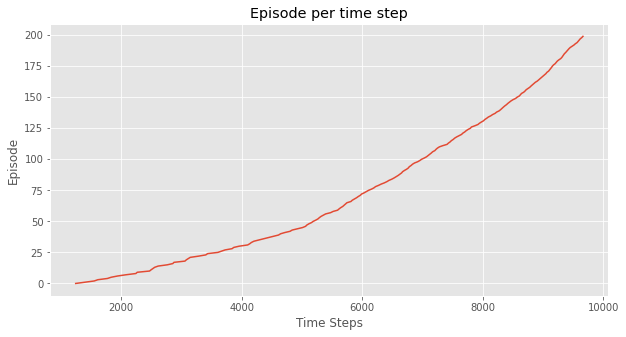

In [18]:
fig = plotting.plot_episode_stats(stats)